# Data Extraction

In [140]:
# Library imports
import requests
import re
import sys
import unicodedata
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Setups
plt.style.use('seaborn')
sns.set_theme()

In [ ]:
automobile_url = "https://www.automobile.it/usate/page-1"
response = requests.get(automobile_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Initialize the empty car list, which will hold all the cars scraped from the website
car_list = []

# The website is structured like this: there is a list of all the cars that are on the market, divided in pages. Each page contains a few cars ads.
# By clicking on an ad, you are then brought to a page with the details related to the car in that ad, like cahracteristics and price.

# Find the maximum number of pages
max_pages = int(soup.find_all('button', class_="jsx-2138479547 font-base auto inline-circled styled value")[-1].text)
# Iterate over the range 1 to max number of pages
for i in range(1, max_pages +1):
    # Construct the url of the page, get the html and parse it
    page_url = "https://www.automobile.it/usate/page-" + str(i)
    page_response = requests.get(page_url)
    print(page_url)
    page_soup = BeautifulSoup(page_response.text, 'html.parser')
    # Extract all the cars ad on the current page and iterate over them
    car_ads_list = page_soup.find_all('a', class_="jsx-2059509079 Card hover-effect CardAd")
    for car_ad in car_ads_list:
        # Create empty car object
        car = {}
        # Extract the url of the details of the ad, get the html and parse it
        car_details_page_url = "https://www.automobile.it" + car_ad.attrs['href']
        print(car_details_page_url)
        car_details_response = requests.get(car_details_page_url)
        car_details_page = BeautifulSoup(car_details_response.text, 'html.parser')
        # Sometimes the links are broken and lead to a 404 page, if that is the case this iteration will be skipped
        if car_details_page.find('div', class_='jsx-1421767171 PageNotFound'):
            continue
        # Get the price and assign it to the car object
        car_price = car_details_page.find('span',class_="jsx-139447011 Price").text
        car['price'] = car_price
        # Get the car characteristics groups and iterate over them
        car_characteristics_groups = car_details_page.find_all('div', class_="jsx-3587327592 Item")
        for characteristic_group in car_characteristics_groups:
            # Get the category name for the characteristics group
            characteristic_category = characteristic_group.find('span').text
            # Initialize an empty list
            characteristics_list = []
            # Find all characteristics and iterate over them if they are more than 1, adding them to the list. Then add it to the car object, with the category as key.
            characteristics = characteristic_group.find_all('div')
            if len(characteristics) > 1:
                for characteristic in characteristics:
                    characteristics_list.append(characteristic.text)
                car[characteristic_category] = characteristics_list
            else:
                car[characteristic_category] = characteristics[0].text
        # Append the new car object to the car list
        car_list.append(car)

# TODO - Add Km 0 cars to the data set
        

In [2]:
# Convert the car list to a data frame, and save it to a csv file for safe keeping
df = pd.DataFrame(car_list)
df.to_csv("data.csv", sep="\t")

NameError: name 'car_list' is not defined

# Data Wrangling

In [164]:
# Create a data frame starting from the csv file
df = pd.read_csv("data.csv", sep='\t', index_col=0)
# Drop the description column, as I don't think it's useful. The new data extraction algorithm doesn't collect it anymore
df.drop('description', axis=1, inplace=True)
# Drop other less useful columns
df.drop('Tipo di usato', axis=1, inplace=True)
df.drop('Tipologia', axis=1, inplace=True)
# The data has a few missing values, but four columns are considered crucial in order to define a used car: its price, its model, its brand, and its
# kilometer count. Without a single one of those the used car doesn't make sense, so it will be dropped. For the kilometers, the website has a section dedicated
# to 0 kms car, which is not included in the dataset for the momenti
df.dropna(subset=['price','Marca','Modello','Chilometri'], inplace=True)


In [165]:
# Remove the points and euro sign from price column, and convert it to numeric
df['price'].replace({'\.':'', '€ ':''}, regex=True, inplace=True)
df['price'] = pd.to_numeric(df['price'])
#Remove the points from the kilometer column
df['Chilometri'] = df['Chilometri'].astype('str')
df['Chilometri'].replace({'\.':'', '€ ':''}, regex=True, inplace=True)
df['Chilometri'] = pd.to_numeric(df['Chilometri'], errors='coerce')
# Remove the month from Immatricolazione column, and make it a date
df['Immatricolazione'] = df['Immatricolazione'].str.replace(r'[A-Za-z]','', regex=True)
df['Immatricolazione'] = df['Immatricolazione'].str.lstrip()
df['Immatricolazione'] = pd.to_datetime(df['Immatricolazione'], format='%Y')
# Split the power column into kw and CV, and convert it to numeric
df[['Potenza-kW', 'Potenza-CV']] = df['Potenza'].str.split('(', expand=True)
df['Potenza-CV'] = df['Potenza-CV'].str.replace(' CV)', '', regex=False)
df['Potenza-kW'] = df['Potenza-kW'].str.replace(' kW', '', regex=False)
df['Potenza-CV'] = pd.to_numeric(df['Potenza-CV'])
df['Potenza-kW'] = pd.to_numeric(df['Potenza-kW'])
# Convert cilindrata to numeric
df['Cilindrata'] = df['Cilindrata'].str.replace(' cm³', '', regex=False)
df['Cilindrata'] = pd.to_numeric(df['Cilindrata'])
# Convert filtro antiparticolato NaN to No
df['Filtro antiparticolato'].replace(np.nan, '0', inplace=True)
df['Filtro antiparticolato'].replace('Sì', '1', inplace=True)
df['Filtro antiparticolato'] = df['Filtro antiparticolato'].astype('int')
# Convert consumo combinato to numeric
# TODO - Deal with the different units --> maybe split columns
df['Consumo combinato'] = df['Consumo combinato'].str.replace(' l/100 km', '', regex=False)
df['Consumo combinato'] = df['Consumo combinato'].str.replace(' Kg/100 km', '', regex=False)
df['Consumo combinato'] = df['Consumo combinato'].str.replace(' kWh/100 km', '', regex=False)
df['Consumo combinato'] = pd.to_numeric(df['Consumo combinato'])
# Convert consumo extraurbano to numeric
# TODO - Deal with the different units --> maybe split columns
df['Consumo extraurbano'] = df['Consumo extraurbano'].str.replace(' l/100 km', '', regex=False)
df['Consumo extraurbano'] = df['Consumo extraurbano'].str.replace(' Kg/100 km', '', regex=False)
df['Consumo extraurbano'] = df['Consumo extraurbano'].str.replace(' kWh/100 km', '', regex=False)
df['Consumo extraurbano'] = pd.to_numeric(df['Consumo extraurbano'])
# Convert consumo urbano to numeric
# TODO - Deal with the different units --> maybe split columns
df['Consumo urbano'] = df['Consumo urbano'].str.replace(' l/100 km', '', regex=False)
df['Consumo urbano'] = df['Consumo urbano'].str.replace(' Kg/100 km', '', regex=False)
df['Consumo urbano'] = df['Consumo urbano'].str.replace(' kWh/100 km', '', regex=False)
df['Consumo urbano'] = pd.to_numeric(df['Consumo urbano'])
# Convert emissioni CO2 to numeric
df['Emissioni CO2'] = df['Emissioni CO2'].str.replace(' g/Km', '', regex=False)
df['Emissioni CO2'] = pd.to_numeric(df['Emissioni CO2'])
# Convert metallizzazo NaN to No
df['Metallizzato'].replace(np.nan, '0', inplace=True)
df['Metallizzato'].replace('Sì', '1', inplace=True)
df['Metallizzato'] = df['Metallizzato'].astype('int')
# Convert In grado di viaggiare NaN to No
df['In grado di viaggiare'].replace(np.nan, '0', inplace=True)
df['In grado di viaggiare'].replace('Sì', '1', inplace=True)
df['In grado di viaggiare'] = df['In grado di viaggiare'].astype('int')
# Convert Scadenza Revisione to datetime
df['Scadenza Revisione'] = df['Scadenza Revisione'].astype('str')
df['Scadenza Revisione'] = df['Scadenza Revisione'].str.replace('.0', '', regex=False)
df['Scadenza Revisione'] = pd.to_datetime(df['Scadenza Revisione'])
# Convert Iva deducibile NaN to No
df['IVA deducibile'].replace(np.nan, '0', inplace=True)
df['IVA deducibile'].replace('Sì', '1', inplace=True)
df['IVA deducibile'] = df['IVA deducibile'].astype('int')

# To make it easier to manage the data visualization and exploration, I'll create a copy of the dataframe at this point and I'll do one hot encoding only on the copy

features = df



In [166]:
# Some columns contains list of values, so a function is used to get the single elements and convert them to dummy variables
def clean_list_columns(df, chosen_option):
    # TODO - Change the data extraction algorithm to not store a list but a string
    # Clean the string values
    df[chosen_option].replace(np.nan, chosen_option + '_No', inplace=True)
    df[chosen_option] = df[chosen_option].str.replace('\'', '', regex=False)
    df[chosen_option] = df[chosen_option].str.replace('[', '', regex=False)
    df[chosen_option] = df[chosen_option].str.replace(']', '',regex=False)
    # Initialize an empty list that will contains unique options
    options_list = []
    # Iterate over all rows
    for index, row in df.iterrows():
        # Split the strings into a list of string, iterate over it and appen the option to the options list if it's not there
        options = row[chosen_option].split(',')
        for option in options:
            if option.lstrip() not in options_list:
                options_list.append(option.lstrip())
    # Iterate over the option list and create a new column for each option that equals 1 if the original column contains the option, 0 if it doesn't
    for option in options_list:
        df[chosen_option + '_' + option] = np.where(df[chosen_option].str.contains(option), 1, 0)


for option in ['Multimedia','Sicurezza', 'Comfort', 'Varie','Luci','Trasporto','Assetto']:
    clean_list_columns(features, option)
    features.drop(option, axis=1, inplace=True)

dummies = ['Marca', 'Modello', 'Carburante', 'Cambio','Numero di porte','Numero di posti', 'Classe emissioni','Colore esterno','Design Interni','Colore Interni','Proprietari precedenti']
features = pd.get_dummies(features, columns=dummies, prefix=dummies)

# Data Visualisation

[Text(0, 0, 'ABARTH'),
 Text(1, 0, 'ALFA ROMEO'),
 Text(2, 0, 'AUDI'),
 Text(3, 0, 'BMW'),
 Text(4, 0, 'CHEVROLET'),
 Text(5, 0, 'CITROEN'),
 Text(6, 0, 'CUPRA'),
 Text(7, 0, 'DACIA'),
 Text(8, 0, 'DAIHATSU'),
 Text(9, 0, 'DODGE'),
 Text(10, 0, 'DR'),
 Text(11, 0, 'DS'),
 Text(12, 0, 'FERRARI'),
 Text(13, 0, 'FIAT'),
 Text(14, 0, 'FORD'),
 Text(15, 0, 'HONDA'),
 Text(16, 0, 'HYUNDAI'),
 Text(17, 0, 'IVECO'),
 Text(18, 0, 'JAGUAR'),
 Text(19, 0, 'JEEP'),
 Text(20, 0, 'KIA'),
 Text(21, 0, 'LANCIA'),
 Text(22, 0, 'LAND ROVER'),
 Text(23, 0, 'LEXUS'),
 Text(24, 0, 'MASERATI'),
 Text(25, 0, 'MAZDA'),
 Text(26, 0, 'MERCEDES BENZ'),
 Text(27, 0, 'MG'),
 Text(28, 0, 'MINI'),
 Text(29, 0, 'MITSUBISHI'),
 Text(30, 0, 'NISSAN'),
 Text(31, 0, 'OPEL'),
 Text(32, 0, 'PEUGEOT'),
 Text(33, 0, 'PORSCHE'),
 Text(34, 0, 'RENAULT'),
 Text(35, 0, 'SEAT'),
 Text(36, 0, 'SKODA'),
 Text(37, 0, 'SMART'),
 Text(38, 0, 'SSANGYONG'),
 Text(39, 0, 'SUBARU'),
 Text(40, 0, 'SUZUKI'),
 Text(41, 0, 'TOYOTA'),
 Text(42

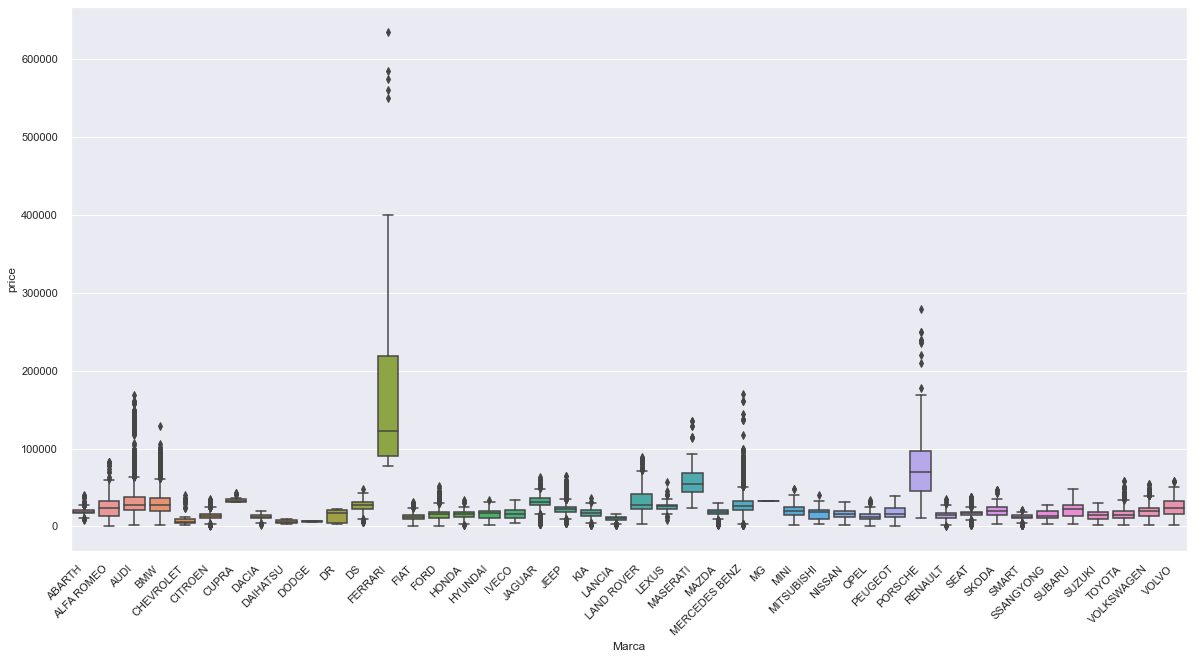

In [181]:
# Create the figure
brand_boxplot_fig, brand_boxplot_ax = plt.subplots()
# Create the plots
sns.boxplot(data=df, x='Marca', y='price', ax=brand_boxplot_ax, order=sorted(df['Marca'].unique().tolist()))
# Set properties
brand_boxplot_fig.set_size_inches(20,10)
brand_boxplot_ax.set_xticklabels(brand_boxplot_ax.get_xticklabels(), rotation=45, ha='right')